## Grad-CAM

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/blackbox.png
" width="1200">

While deep learning has facilitated unprecedented accuracy in image classification, object detection, and image segmentation, one of their biggest problems is model interpretability, a core component in model understanding and model debugging. In practice, deep learning models are treated as “black box” methods, and many times we have no reasonable idea as to: where the network is “looking” in the input image, Which series of neurons activated in the forward-pass during inference/prediction. How the network arrived at its final output that raises an interesting question — how can you trust the decisions of a model if you cannot properly validate how it arrived there?

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/grad.png
" width="1200">



Class Activation Maps (CAMs) are visualization methods used for explaining deep learning models. In this method, the model predicted class scores are traced back to the last convolution layer to highlight discriminative regions of interest in the image that are class-specific and not even generic to other computer vision or image processing algorithms. Gradient CAM or popularly called as Grad-CAMs combines the effect of guided backpropagation and CAM to highlight class discriminative regions of interest without highlighting the granular pixel importance. But Grad-CAM can be applied to any CNN architectures, unlike CAM, which can be applied to architectures that perform global average pooling over output feature maps coming from the convolution layer, just prior to the prediction layer. To get a more detailed understanding on the Grad-CAM process, you can have a look at this research paper Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, Ramprasaath et. al — https://arxiv.org/abs/1610.02391.

Grad-CAM uses the gradients of any target concept (say logits for “dog” or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.”

Using Grad-CAM, we can visually validate where our network is looking, verifying that it is indeed looking at the correct patterns in the image and activating around those patterns. If the network is not activating around the proper patterns/objects in the image, then we know: our network hasn’t properly learned the underlying patterns in our dataset Our training procedure needs to be revisited We may need to collect additional data And most importantly, our model is not ready for deployment. Grad-CAM is a tool that should be in any deep learning practitioner’s toolbox — take the time to learn how to apply it now.

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/gradd.png
" width="1200">

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

### Gradient Class Activation Map (Grad-CAM)

The popular technique of Grad-CAM is used as a visualization technique to explain the working of complex Convolution Neural Networks on unstrutured data like images. We will use tensorflow and keras framework to get a pretrained network on ImageNet dataset and test the approach on a sample open image obtained from the source: https://i.imgur.com/GleAY3f.jpeg. For more examples using Keras and tensorflow please visit: https://keras.io/examples/

In [ ]:
model_builder = Xception
preprocess_input = preprocess_input
decode_predictions = decode_predictions
IMG_SIZE = (299, 299)
last_conv_layer = "block14_sepconv2_act"

### Loading the data

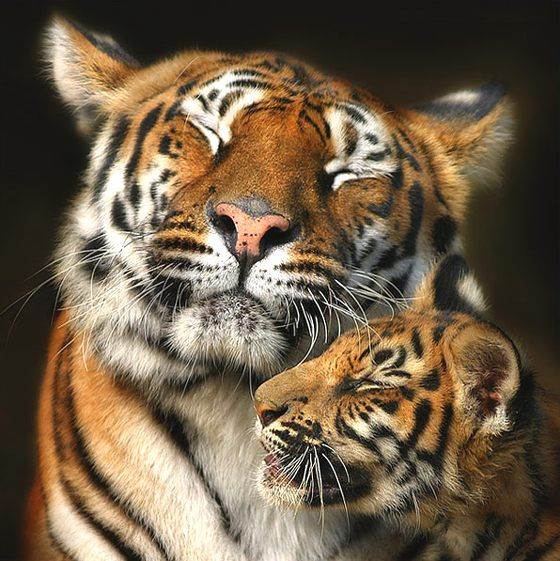

In [ ]:
image_path = keras.utils.get_file("tiger.jpg", "https://i.imgur.com/GleAY3f.jpeg")
display(Image(image_path))

### Preprocessing

In [ ]:
def vectorize_image(img_path, size):
    '''
    Vectorize the given image to get a numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    return array

In [ ]:
vectorized_image = preprocess_input(vectorize_image(image_path, size=IMG_SIZE))
model = model_builder(weights="imagenet")
model.layers[-1].activation = None # Removing the last layer as it is the softmax layer used for classification

model_prediction = model.predict(vectorized_image)
print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")

35363/35363 [==============================] - 0s 0us/step
The predicted class is : tiger


### Building Grad-CAM Heat-map

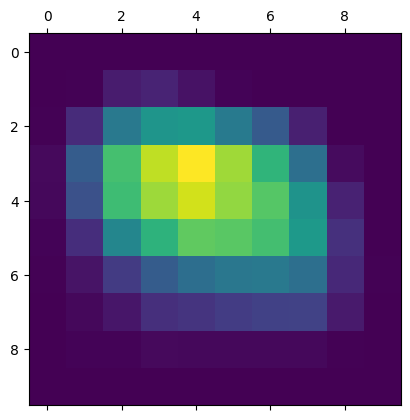

In [ ]:
def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

### Superimpose Grad-CAM Heatmap on image

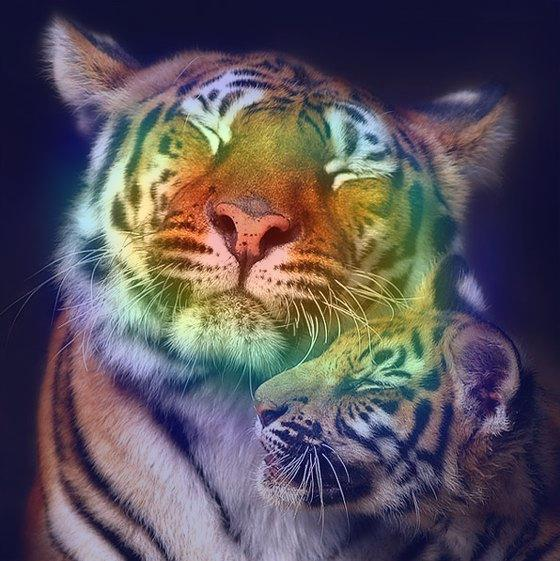

In [ ]:
def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.4):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)


    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    display(Image(output_path)) # Displaying Grad-CAM Superimposed Image

superimpose_gradcam(image_path, get_heatmap(vectorized_image, model, last_conv_layer))

This is a very powerful technique that is used to explain the working of complex Deep Learning algorithms on unstructured data like images. Although this method is difficult to unerstand for beginner learners, but once you get a hang of it, it is a very powerful method and very helpful for model explainability,